# NBA Salary Predictions - Data Collection

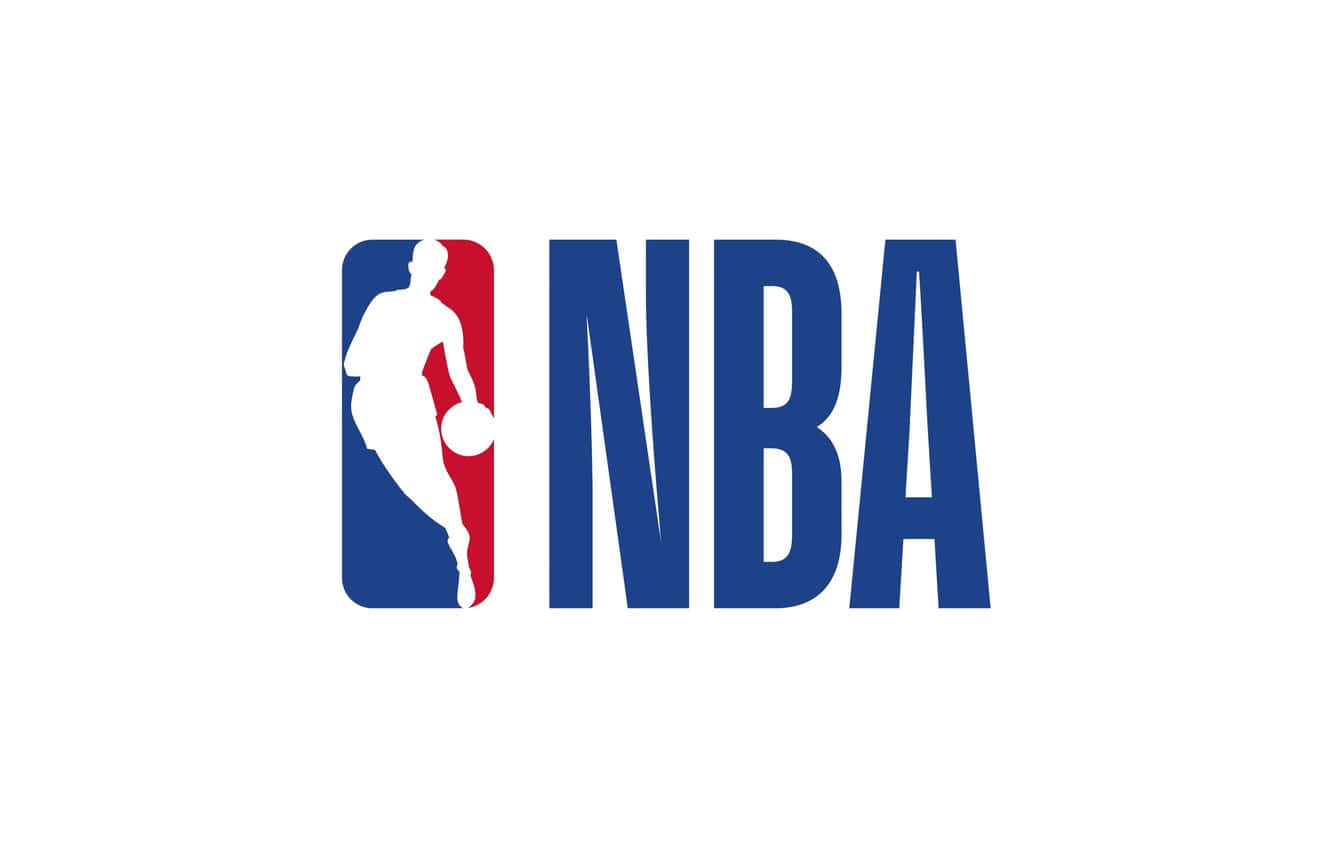

In [ ]:
import requests
import pandas as pd
import time
import json

## 1 Webscrapping Salaries

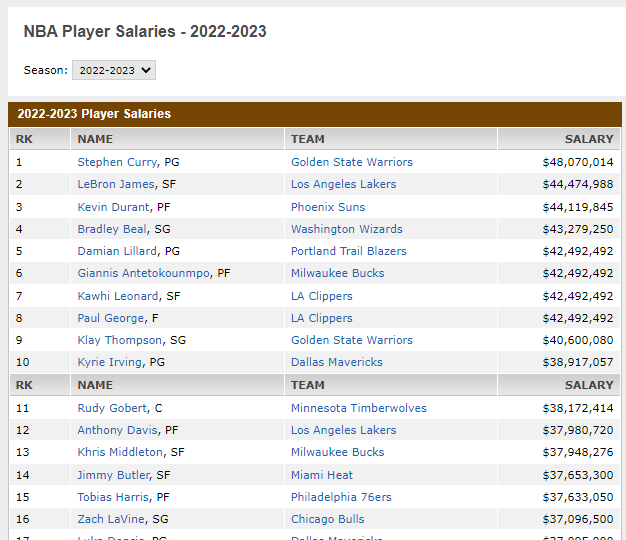

In [ ]:
# Get a List of ESPN web page URL's. Each URL display one HTML table with the salary data. 
url_list=[]

for page in range(1,14):
    url='http://www.espn.com/nba/salaries/_/page/'+ str(page) + '/seasontype/3'
    url_list.append(url)

In [ ]:
df_list = []
for url in url_list:
    df_list.append(pd.read_html(url)[0]) 

In [ ]:
df_salary = pd.concat(df_list)
df_salary.columns = ['Rank', 'Name','Team', 'Salary']

In [ ]:
df_salary.drop(df_salary[df_salary['Rank'] == 'RK'].index, axis=0, inplace = True)

Player Salaries Table 

In [ ]:
df_salary['Name'] = df_salary['Name'].apply(lambda name: name.split(',')[0])  
df_salary.head(15)

,Rank,Name,Team,Salary
1,1,Stephen Curry,Golden State Warriors,"$48,070,014"
2,2,LeBron James,Los Angeles Lakers,"$44,474,988"
3,3,Kevin Durant,Phoenix Suns,"$44,119,845"
4,4,Bradley Beal,Washington Wizards,"$43,279,250"
5,5,Damian Lillard,Portland Trail Blazers,"$42,492,492"
6,6,Giannis Antetokounmpo,Milwaukee Bucks,"$42,492,492"
7,7,Kawhi Leonard,LA Clippers,"$42,492,492"
8,8,Paul George,LA Clippers,"$42,492,492"
9,9,Klay Thompson,Golden State Warriors,"$40,600,080"
10,10,Kyrie Irving,Dallas Mavericks,"$38,917,057"


In [ ]:
df_salary.shape

(520, 4)

## 2 Player Information

The <a href='https://www.balldontlie.io/home.html#introduction'>balldontlie</a> is a free API service that allows one to retrieve players, teams, and game information, including game statistics and season averages for a specific player. The player information can be obtained by querying with the name in "salaries" table (df_salary) using the player's name.

The endpoint is the one bellow:
"https://www.balldontlie.io/api/v1/players?search={name}"

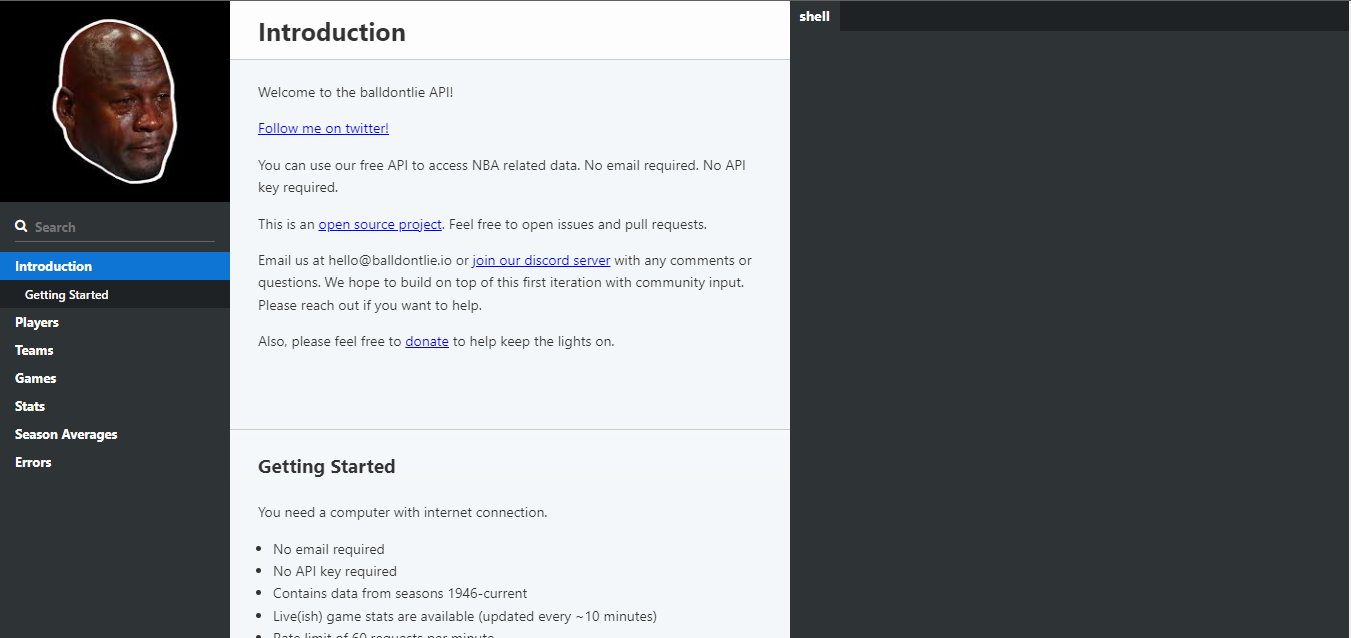

Getting the personal information by quering with the player name from the df_salary DataFrame.

In [ ]:
def get_all_players(salary):
  all_players = []
  # API call to retrieve player info for a player name on the DataFrame
  req_num = 0

  for name in salary['Name']:
    response_all_players = requests.get(url=f"https://www.balldontlie.io/api/v1/players?search={name}")
    player_info = response_all_players.json()
  
    # Check if the data was successfully obtained 
    if player_info['data'] != []:
      all_players.append(player_info['data'][0])
    
    req_num += 1
    if req_num >= 60:
      time.sleep(65)
      req_num = 0

  # delete the team info
  for player in all_players:  
    del player['team']

  return all_players



In [ ]:
players_info = get_all_players(salary = df_salary)
print(df_salary.shape)
len(players_info)

(520, 4)


510

In [ ]:
# Formatting the dataframe
df_players = pd.DataFrame.from_dict(players_info)

df_players['name'] = df_players['first_name'] + " " + df_players['last_name']
df_players.drop(['first_name', 'last_name'], axis=1, inplace=True)

df_players['height']= df_players['height_feet'] + (df_players['height_inches']/10)
df_players.drop(['height_feet', 'height_inches'], axis=1, inplace=True)



df_players.head()

,id,position,weight_pounds,name,height
0,115,G,190.0,Stephen Curry,6.3
1,237,F,250.0,LeBron James,6.8
2,140,F,240.0,Kevin Durant,6.9
3,37,G,207.0,Bradley Beal,6.5
4,278,G,195.0,Damian Lillard,6.3


In [ ]:
df_players.rename(columns={'name': 'Name'}, inplace=True)

In [ ]:
df_players.tail()

,id,position,weight_pounds,Name,height
505,17896120,F,NaN,Ish Wainright,NaN
506,31,G,190.0,Will Barton,6.6
507,666873,F,NaN,Isaiah Roby,NaN
508,136,G,190.0,Goran Dragic,6.3
509,17896059,F,NaN,Sandro Mamukelashvili,NaN


## 3 Merging Players Salaries and Personal Information

Merge the df_salary with the df_players on the "Name" feature.

In [ ]:
df_players_salaries = df_players.merge(df_salary, how='inner', on='Name')

In [ ]:
df_players_salaries.shape

(509, 8)

In [ ]:
df_players_salaries.head()

,id,position,weight_pounds,Name,height,Rank,Team,Salary
0,115,G,190.0,Stephen Curry,6.3,1,Golden State Warriors,"$48,070,014"
1,237,F,250.0,LeBron James,6.8,2,Los Angeles Lakers,"$44,474,988"
2,140,F,240.0,Kevin Durant,6.9,3,Phoenix Suns,"$44,119,845"
3,37,G,207.0,Bradley Beal,6.5,4,Washington Wizards,"$43,279,250"
4,278,G,195.0,Damian Lillard,6.3,5,Portland Trail Blazers,"$42,492,492"


## 4 Players Stats 

From the players' information data, the player ID can be used to retrieve the average stats for a desired season. By using the player ID, you can fetch the statistics average for the specified season.

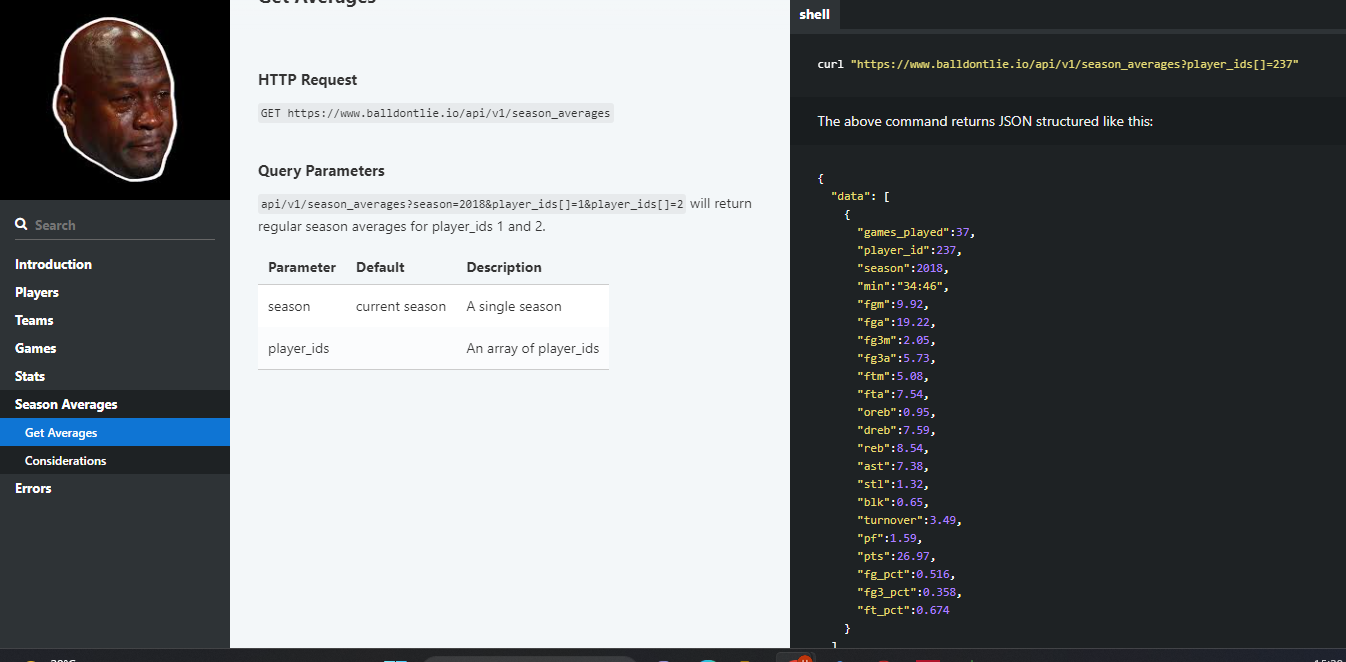

In [ ]:
from requests.models import HTTPError
url = "https://www.balldontlie.io/api/v1/season_averages"


try:
  params1 = {"season": "2022", "player_ids[]":df_players['id'][:370]}
  response1 = requests.get(url=url, params=params1)
  params2 = {"season": "2022", "player_ids[]":df_players['id'][370:len(df_players['id'])]}
  response2 = requests.get(url=url, params=params2)
  
except HTTPError:
    print("Failed") 

players_stats1 = response1.json()
players_stats2 = response2.json()
len(players_stats2["data"])

Success


110

In [ ]:
df_stats1 = pd.DataFrame.from_dict(players_stats1["data"])
df_stats2 = pd.DataFrame.from_dict(players_stats2["data"])
df_stats = pd.concat([df_stats1, df_stats2])
df_stats.rename(columns={"player_id": "id"}, inplace=True)
df_stats.head()

,games_played,id,season,min,fgm,fga,fg3m,fg3a,ftm,fta,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
0,42,3,2022,26:52,3.74,6.26,0.00,0.02,1.12,3.07,...,11.55,2.33,0.86,1.10,1.88,2.33,8.60,0.597,0.000,0.364
1,77,4,2022,34:45,7.90,14.74,0.01,0.16,4.31,5.38,...,9.27,3.22,1.19,0.83,2.48,2.77,20.12,0.536,0.083,0.802
2,72,8,2022,27:24,3.40,7.74,2.03,5.08,1.58,1.75,...,3.29,2.26,0.86,0.19,1.00,1.63,10.42,0.440,0.399,0.905
3,68,9,2022,32:45,5.93,9.21,0.01,0.15,2.38,3.25,...,9.79,1.66,0.79,1.24,1.37,2.25,14.25,0.644,0.100,0.733
4,71,12,2022,28:36,3.68,7.30,0.66,1.59,1.42,1.93,...,5.34,4.96,1.15,0.96,1.55,2.15,9.44,0.504,0.416,0.737


In [ ]:
df_stats.shape

(453, 22)

In [ ]:
df_final = df_players_salaries.merge(df_stats, on='id', how="inner")
df_final.head()

,id,position,weight_pounds,Name,height,Rank,Team,Salary,games_played,season,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
0,115,G,190.0,Stephen Curry,6.3,1,Golden State Warriors,"$48,070,014",56,2022,...,6.09,6.29,0.93,0.36,3.20,2.09,29.43,0.493,0.427,0.915
1,237,F,250.0,LeBron James,6.8,2,Los Angeles Lakers,"$44,474,988",56,2022,...,8.34,6.80,0.91,0.61,3.27,1.66,28.93,0.501,0.324,0.770
2,140,F,240.0,Kevin Durant,6.9,3,Phoenix Suns,"$44,119,845",47,2022,...,6.66,5.00,0.72,1.43,3.32,2.11,29.06,0.560,0.404,0.919
3,37,G,207.0,Bradley Beal,6.5,4,Washington Wizards,"$43,279,250",50,2022,...,3.92,5.42,0.90,0.66,2.90,2.14,23.20,0.506,0.365,0.842
4,278,G,195.0,Damian Lillard,6.3,5,Portland Trail Blazers,"$42,492,492",58,2022,...,4.78,7.33,0.86,0.31,3.29,1.88,32.17,0.463,0.371,0.914


## 5 Data Formating

In [ ]:
df_final['Salary']=df_final['Salary'].str.replace("$", '')
df_final['Salary']=df_final['Salary'].str.replace(",", '')
df_final['Salary']=pd.to_numeric(df_final['Salary'])

<ipython-input-21-45abc4279b1d>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final['Salary']=df_final['Salary'].str.replace("$", '')


In [ ]:
df_final.head()

,id,position,weight_pounds,Name,height,Rank,Team,Salary,games_played,season,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
0,115,G,190.0,Stephen Curry,6.3,1,Golden State Warriors,48070014,56,2022,...,6.09,6.29,0.93,0.36,3.20,2.09,29.43,0.493,0.427,0.915
1,237,F,250.0,LeBron James,6.8,2,Los Angeles Lakers,44474988,56,2022,...,8.34,6.80,0.91,0.61,3.27,1.66,28.93,0.501,0.324,0.770
2,140,F,240.0,Kevin Durant,6.9,3,Phoenix Suns,44119845,47,2022,...,6.66,5.00,0.72,1.43,3.32,2.11,29.06,0.560,0.404,0.919
3,37,G,207.0,Bradley Beal,6.5,4,Washington Wizards,43279250,50,2022,...,3.92,5.42,0.90,0.66,2.90,2.14,23.20,0.506,0.365,0.842
4,278,G,195.0,Damian Lillard,6.3,5,Portland Trail Blazers,42492492,58,2022,...,4.78,7.33,0.86,0.31,3.29,1.88,32.17,0.463,0.371,0.914


In [ ]:
df_final.drop(['weight_pounds', 'height', 'Rank', 'season', 'min'], axis=1, inplace=True)

## 6 Export CSV

In [ ]:
df_final.to_csv("stats_salaries.csv")